### Resources used:
- [Tackling the Qubit Mapping Problem for NISQ-Era Quantum Devices](https://arxiv.org/pdf/1809.02573)
- [IBM Qiskit Routing](https://www.youtube.com/watch?v=jHx7oZfI7jw)
- [IBM Qiskit Layout](https://www.youtube.com/watch?v=qcFp90vbc6U&t=88s)
- [Compilation: Mapping | Quantum Computer Systems @UChicago, Jonathan Baker](https://www.youtube.com/watch?v=2EWxJ1saWmo&list=PLfOgkuiMs5qCa8BUrFMumyvPqeoOL-iu8&index=13)
- [Compilation: Routing | Quantum Computer Systems @UChicago, Jonathan Baker](https://www.youtube.com/watch?v=mzUlfshGJ9M&list=PLfOgkuiMs5qCa8BUrFMumyvPqeoOL-iu8&index=14)
- [Fast Qubit Placement in 2D Architecture Using Nearest Neighbor Realization](https://ieeexplore.ieee.org/document/7434405)

In [1]:
from draw import *

## Which type of hardware/qubits have the constraints what make mapping important?

### Superconducting and NV Center qubits have connectivity constraints. In superconducting quantum hardware, qubit-qubit interaction is facilitated through resonators and capacitive/inductive links. These connections can only be made on neighbouring qubits. NV center qubits depend on nitrogen vacancy defects in a diamond lattice structure. Connecting all defects with each other will result in error propogation and isolation of qubits will not be possible.

### As far as I know Ion-Trap qubits do not have such constraints if we look at qubits in a single isolated trap. All qubits in a single trap can interact with each other, but qubits in different traps need to be connected. But higher connectivity results in unwanted crosstalk and ion traps have generally slower gate speed.

## <span style="color: red;">ASSUMPTION: In this whole assignment, I am assuming the two qubit gates are CNOT gates with the first qubit from top being control and 2nd being target. The order of CNOT changes the results.</span>


In [2]:
import pennylane as qml
from pennylane import numpy as np
from collections import *
import matplotlib.pyplot as plt
import networkx as nx
import math

In [3]:
# Physical qubits on hardware:
physical_qubits = [0, 1, 2, 3, 4]

# Adjacency list for the T-shaped device:
device_graph = {
    0: [1],
    1: [0, 2, 3],
    2: [1],
    3: [1, 4],
    4: [3]
}

In [4]:
# Each gate is represented as (gate_type, [qubit(s)], gate_id)
# For a two-qubit gate, store something like ("CNOT", [control, target], gate_id)
# For a single-qubit gate, store e.g. ("H", [target], gate_id)

circuit = [
    ("CNOT", [0, 1], "g1"),
    ("CNOT", [0, 2], "g2"),
    ("CNOT", [1, 3], "g3"),
    ("CNOT", [0, 4], "g4"),
    ("CNOT", [2, 4], "g5")
]

# Question 1:
## Manually solve the qubit mapping problem for the circuit shown in Figure below using as less SWAP gates as possible.

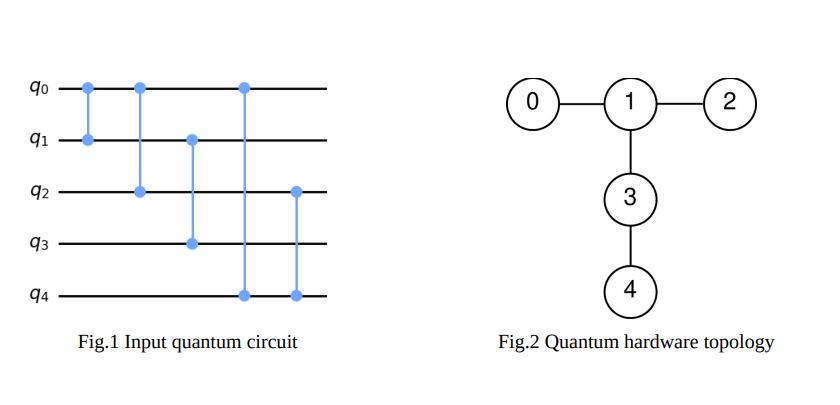

#### We need to map the logical quantum circuit in Figure 1 to the Physical qubit topology in Figure 2 using as few SWAP gates as possible.
#### Taken inspiration from "Fast Qubit Placement in 2D Architecture Using Nearest Neighbor Realization", Shrivastwa et al.

### STEP 1: Create Adjacency Matrix that calculates interactions between the logical qubits.

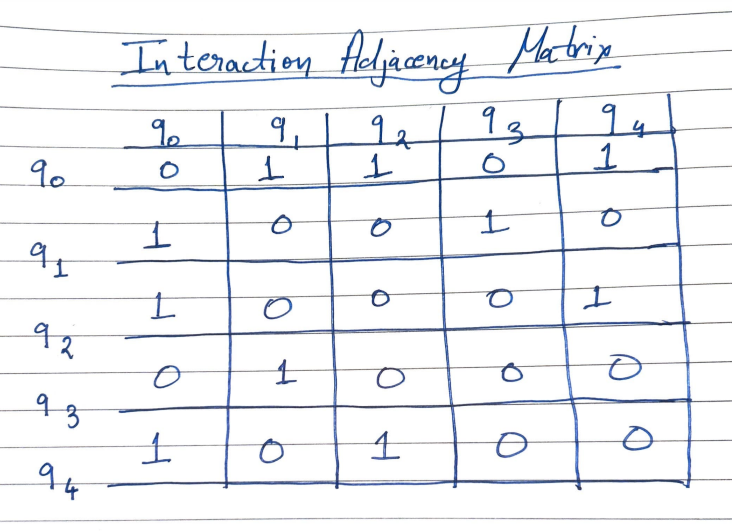

#### The above adjacency matrix is created by observing the interactions between qubits in a pairwise manner

### STEP 2: Create Priority Stack for the qubits.

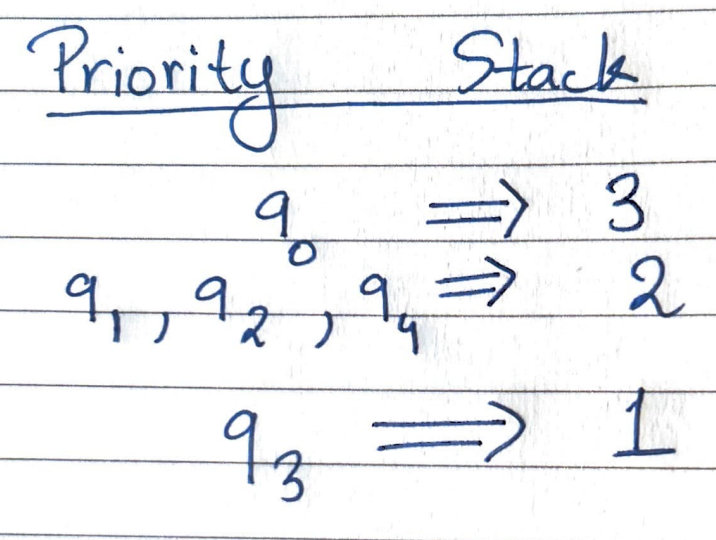

#### The above Priority Stack is a sorted list in descending order according to the total number of interactions a qubit has.

### STEP 2: Map the qubit at the top of the Priority Stack to the node in the Physical Device Graph with the highest Eigenvector or Katz Centrality metric. Remove the mapped qubit from the Priority Stack and put it in a variable called **"current_parent"**.

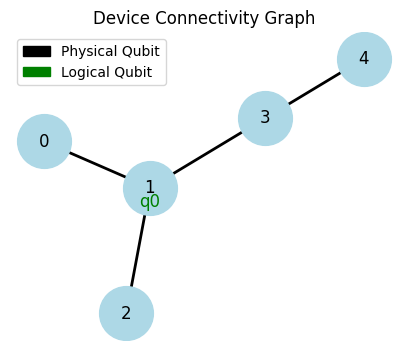

In [5]:
draw_physical_qubit_graph(device_graph,[(1,"q0")])

#### We can see above that we assigned **q0** to physical qubit **1**. This is because the degree of physical qubit 1 was 3 (Highest out of all other Nodes). In this case, since the graph is small and easily decipherable, I used degree as a substitute for centrality measures. Incase the graph is big with multiple nodes connected to each other with varying degrees, the **Eigenvector** or **Katz Centrality** metric will be a great metric for choosing the nodes as just using degree may cause a qubit to be mapped to a node with high degree but with less edges between subsequent generations. This will result in a mapping requiring more SWAPS.

### New Priority Stack:
- **q1, q2, q4 > 2**
- **q3 > 1**

### **current_parent = q0**

#### **<span style="color: red;">(This reasoning and mapping strategy is not from the paper. More analysis is required for better understanding)</span>**

### STEP 3: 
### I. Choose a logical qubit which is a neighbour of current_parent from the top of the Priority Stack. If multiple nodes are available with multiple priority values, choose the one that has the highest for qubits not belonging to neighbour of current_parent. If still multiple nodes are available choose randomly.
### II. Assign chosen logical qubit to physical qubit with highest centrality and the neighbour of the physical qubit that is assigned to current_parent. If multiple physical qubits with same value are available then assign randomly.
### III. Remove assigned qubit form priority stack.

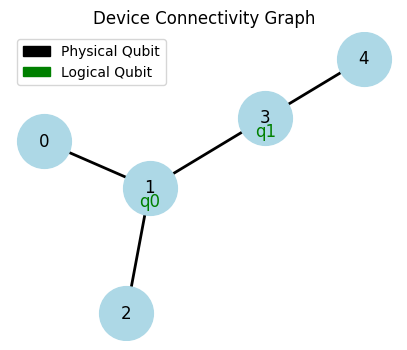

In [6]:
draw_physical_qubit_graph(device_graph,[(1,"q0"),(3,"q1")])

### In our case we have 3 possible qubits, they are q1,q2 and q4 since all three are neighbours of q0, but we will choose q1 since one of it's neighbout is q3 which is not the child for current_parent = q0. Others have their neighbours as q0 or neighbours of q0. We assign q1 to node 3 as it has the next highest degree in the physical qubit graph.

### New Priority Stack:
- **q2, q4 > 2**
- **q3 > 1**

### **current_parent = q0**


### STEP 4: Repeat STEP 3 until all neighbours of "current_parent" have been mapped.

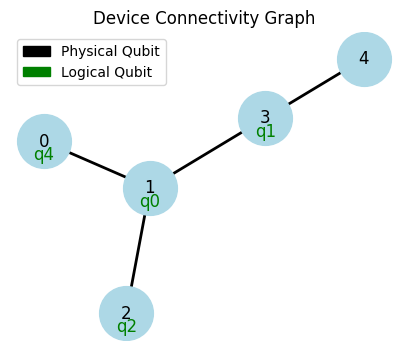

In [7]:
draw_physical_qubit_graph(device_graph,[(1,"q0"),(3,"q1"),(2,"q2"),(0,"q4")])

### New Priority Stack:
- **q3 > 1**

### **current_parent = q0**

### STEP 5: Since all neighbours of current_parent have been exhausted. Choose the next logical qubit from the priority stack. If multiple exist, choose randomly. Continue from STEP 1 till Priority Stack gets empty.

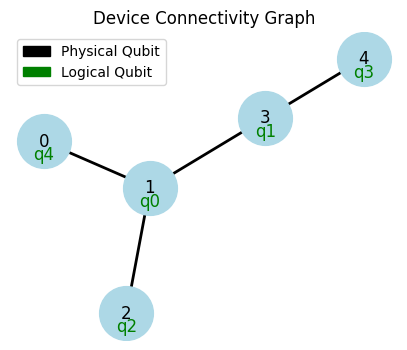

In [8]:
draw_physical_qubit_graph(device_graph,[(1,"q0"),(3,"q1"),(2,"q2"),(0,"q4"),(4,"q3")])

### Since we only had q3 remaing, it got assigned to the reaming physical qubit 4. The priority stack is now empty.

### STEP 6: Execute all gates which do not have any dependency on other qubits in the DAG and are physically possible.

### Circuit DAG:
- **g1** -> ['g2', 'g3', 'g4']
- **g2** -> ['g4', 'g5']
- **g4** -> ['g5']

### We can see that **g1** has no dependency on other gates as it belongs to none of the successor list. After executing **g1** we can also execute **g2** as it was dependent on only **g1**. After that similarly we can execute **g3** and **g4** successively. But executing **g5** is not physically possible as **q2** and **q4** are not adjacent.

### STEP 7: Insert SWAPS to make the gate executable:

### STEP 8: Repeat STEPS 6 and 7 till complete circuit has been executed.

## FINAL CIRCUIT:

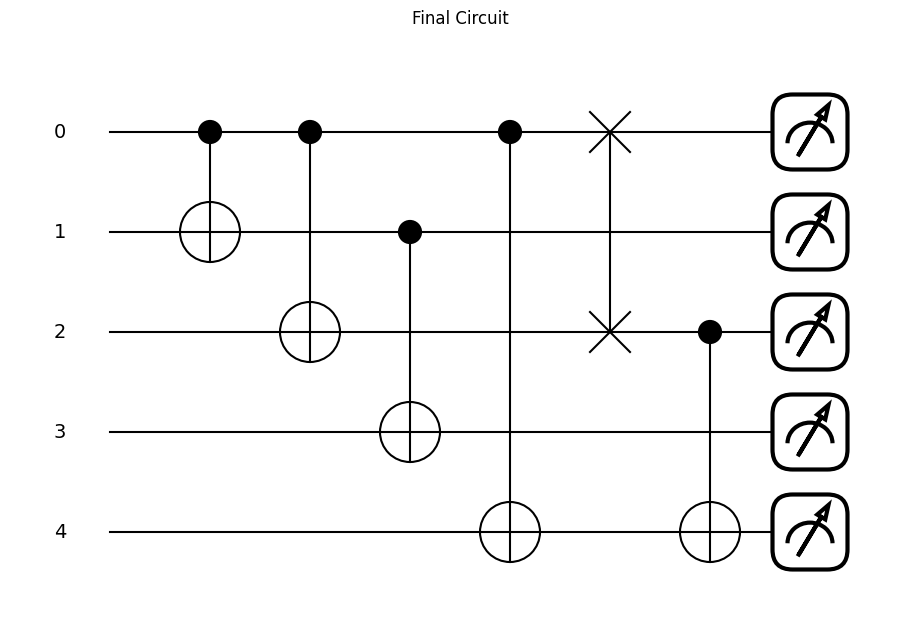

In [9]:
dev = qml.device("default.qubit", wires=5)
def create_final_qnode(dev):

    @qml.qnode(dev)
    def qnode():
        qml.CNOT([0,1])
        qml.CNOT([0,2])
        qml.CNOT([1,3])
        qml.CNOT([0,4])
        qml.SWAP([0,2])
        qml.CNOT([2,4])
        

        return qml.state()

    return qnode

final_qnode = create_final_qnode(dev)

fig, ax = qml.draw_mpl(final_qnode)()
plt.title("Final Circuit")
plt.show()

#### We had to add one SWAP between logical qubit "q0" and "q2" for "g5" gate to execute between "q2" and "q4". This SWAP brought "q2" from 4 to 1 and "q0" from 1 to 4. "q4" was at 0. Hence "q2" and "q4" are now adjacent.